Try to build a neural network to predict price of a laptop. Will use a simple linear regression model and compare accuracy later 

In [91]:
import pandas as pd 
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [92]:
df = pd.read_csv('laptop_clean_dataset.csv')
print(df.columns)
print(df.dtypes)

Index(['Company', 'TypeName', 'Inches', 'Weight', 'screen_resolution',
       'display_type', 'processor_speed', 'processor_brand', 'processor_type',
       'ssd_storage', 'hdd_storage', 'flash_storage', 'ram', 'os', 'Price'],
      dtype='object')
Company               object
TypeName              object
Inches               float64
Weight                object
screen_resolution     object
display_type          object
processor_speed      float64
processor_brand       object
processor_type        object
ssd_storage            int64
hdd_storage           object
flash_storage          int64
ram                    int64
os                    object
Price                float64
dtype: object


Need to convert Weight to numerical data , also need to do one hot encoding on categorical features

In [93]:
df['Weight']= pd.to_numeric(df['Weight'], errors='coerce').astype('float64')

In [94]:
df['Weight']=df['Weight'].fillna(1.18) #from, google

Need to make HDD storage a numerical value

In [95]:
def correct_values(val):
    val = str(val).upper().strip()
  
    if "TB" in val:
        num = float(val.replace('TB', '').replace(' ', ''))
        num = num * 1024
    else:
        num = float(val.replace(' ', ''))

    return num

df['hdd_storage'] = df['hdd_storage'].apply(correct_values)
print(df['hdd_storage'])


print(df.dtypes)

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
         ...  
1238     500.0
1239       0.0
1240       0.0
1241       0.0
1242    1024.0
Name: hdd_storage, Length: 1243, dtype: float64
Company               object
TypeName              object
Inches               float64
Weight               float64
screen_resolution     object
display_type          object
processor_speed      float64
processor_brand       object
processor_type        object
ssd_storage            int64
hdd_storage          float64
flash_storage          int64
ram                    int64
os                    object
Price                float64
dtype: object


Many of the types are categorical values but they have more categories than 1 , so using one hot encoder here , seems helpful  

In [96]:

categorical_cols = ['Company','TypeName','screen_resolution','display_type','processor_brand','processor_type','os']
numeric_cols = ['Inches','Weight','processor_speed','ssd_storage','hdd_storage','flash_storage','ram','Price']


Y = df['Price']
X = pd.get_dummies(df, columns=categorical_cols, dtype=int)
X.drop(columns=['Price'], inplace=True)
print(X.shape)
print(X)
print(X.shape, ' ', Y.shape)


(1243, 151)
      Inches  Weight  processor_speed  ssd_storage  hdd_storage  \
0       13.3    1.37              2.3          128          0.0   
1       13.3    1.34              1.8            0          0.0   
2       15.6    1.86              2.5          256          0.0   
3       15.4    1.83              2.7          512          0.0   
4       13.3    1.37              3.1          256          0.0   
...      ...     ...              ...          ...          ...   
1238    15.6    2.20              2.5            0        500.0   
1239    14.0    1.80              2.5          128          0.0   
1240    13.3    1.30              2.5          512          0.0   
1241    14.0    1.50              1.6            0          0.0   
1242    15.6    2.19              2.5            0       1024.0   

      flash_storage  ram  Company_Acer  Company_Apple  Company_Asus  ...  \
0                 0    8             0              1             0  ...   
1               128    8       

Data is ready for usage 

Splitting the data 

In [97]:
X_train , X_test , Y_train, Y_test = train_test_split(X,Y, test_size=0.15, random_state=42)

#Reset indices
X_train = X_train.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [98]:
model1 = LinearRegression()

def model2():
    return torch.nn.Sequential(
    torch.nn.Linear(X_train.shape[1] , 30),
    torch.nn.ReLU(),
    torch.nn.Linear(30,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,1)
)
def model3():
    return  torch.nn.Sequential(
    torch.nn.Linear(X_train.shape[1] , 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20,1)
)
def model4() :
    return  torch.nn.Sequential(
    torch.nn.Linear(X_train.shape[1] , 70),
    torch.nn.ReLU(),
    torch.nn.Linear(70,30),
    torch.nn.ReLU(),
    torch.nn.Linear(30,5),
    torch.nn.ReLU(),
    torch.nn.Linear(5,1)
)

model_class = [ model2, model3 , model4]
model_names = ["2 layers", "1 layer", '3 layers']

Function to train model  

In [99]:
def train_one(model, train_dl, val_dl, max_epochs=500, patience=20):
    opt = torch.optim.Adam(model.parameters())
    loss_fn =torch.nn.MSELoss()
    best_val = float("inf")
    best_state = None
    no_improve = 0

    for epoch in range(max_epochs):
        model.train()
        for xb, yb in train_dl: # training mode 
            opt.zero_grad() #zero gradient
            pred = model(xb).squeeze(1) #Predicton
            loss = loss_fn(pred, yb) #COmpute the loss
            loss.backward() #compute the gradients
            opt.step()   # update the weights

        model.eval() 
        val_loses=[]
        with torch.no_grad(): # no gradient tracking
            for xb , yb in val_dl:
                pred = model(xb).squeeze(1) #predict with current weights
                val_loses.append(loss_fn(pred, yb).item()) #add loss to prediction list
        val_mse = np.mean(val_loses) # find mean of the list
        if val_mse < best_val - 1e-6: 
            best_val = val_mse
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return np.sqrt(best_val)  # best RMSE

print(X_train.index)
print(Y_train.index)




RangeIndex(start=0, stop=1056, step=1)
RangeIndex(start=0, stop=1056, step=1)


Since data is scarce, we use a K - fold cross validation check instead of the usual split of training , cross validatin and training data 

In [100]:
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        # Convert pandas Series to numpy array if needed
        if hasattr(Y, "to_numpy"):
            Y = Y.to_numpy()
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

K FOLD cross validation :

In [101]:
k = 8 
kf = KFold(n_splits=k , shuffle=True, random_state=2)
fold_root_mean_sq_vals=[]

for model_c , na in zip(model_class, model_names):
    print("Evaluating " , na)
    foldMSE=[]
    res={}
    for fold , (train_indices, val_indices) in enumerate(kf.split(X_train_scaled)):
        X_tr, X_val = X_train_scaled[train_indices], X_train_scaled[val_indices]
        Y_tr, Y_val = Y_train[train_indices], Y_train[val_indices]

        train_dataset = MyDataset(X_tr, Y_tr)
        val_dataset = MyDataset(X_val, Y_val)
        #data loaders :
        train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)

        #Fresh model instance
        m = model_c()

        rmse = train_one(m, train_dl, val_dl,max_epochs=500, patience=20)
        foldMSE.append(rmse)
    avg_rmse = np.mean(foldMSE)
    res[na] = avg_rmse
    print("Average RMSE for model ",na, " : ", avg_rmse)

    



Evaluating  2 layers
Average RMSE for model  2 layers  :  20314.67522528609
Evaluating  1 layer
Average RMSE for model  1 layer  :  42236.17624553655
Evaluating  3 layers
Average RMSE for model  3 layers  :  18647.106398289805


In [102]:
print(Y_train.min(), Y_train.max(), Y_train.mean())

9270.72 324954.72 60683.63844545454


In [103]:
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)



# Create a Dataset and DataLoader
full_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=32, shuffle=True)

# Training loop
def train_full_model(model, loader, epochs=500, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        for xb, yb in loader:
            opt.zero_grad()
            pred = model(xb).squeeze(1)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
    return model

# Train the model
neural_model = model4()
neural_model = train_full_model(neural_model, full_loader, epochs=500, lr=1e-3)


neural_model.eval()
with torch.no_grad():
    p=neural_model(X_test_tensor).squeeze(1)
    mse = torch.mean((p - Y_test_tensor)**2)
    se = np.sqrt(mse)
print("3 layered model RMSE : ", se)

3 layered model RMSE :  tensor(17824.8848)


C:\Users\tanji\AppData\Local\Temp\ipykernel_21008\309979662.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  se = np.sqrt(mse)


In [104]:
model1.fit(X_train_scaled, Y_train)
preds = model1.predict(X_test_scaled)
rms = np.sqrt(np.mean((preds-Y_test)**2))
print("Linear regression model pediction : ", rms)


Linear regression model pediction :  18433.341390593614


plotting the results :

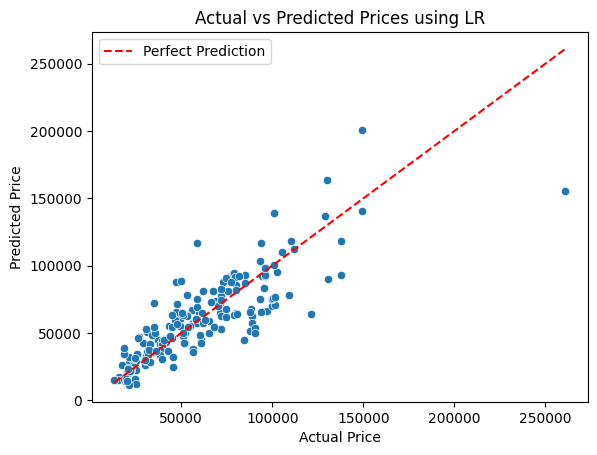

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assume preds and Y_test are defined
plot_df = pd.DataFrame({'Actual': Y_test, 'Predicted': preds})

sns.scatterplot(x='Actual', y='Predicted', data=plot_df)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted Prices using LR')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

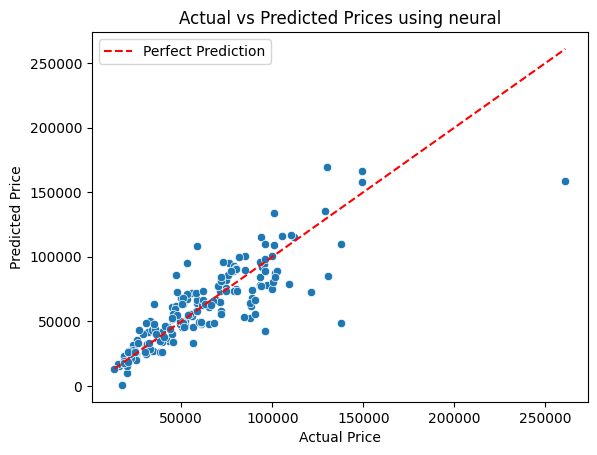

In [106]:
plot_df = pd.DataFrame({'Actual': Y_test, 'Predicted': p})

sns.scatterplot(x='Actual', y='Predicted', data=plot_df)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted Prices using neural')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

RMSE for the training set and the test set :|

In [107]:
# RMSE for training set
neural_model.eval()
with torch.no_grad():
    train_preds = neural_model(X_train_tensor).squeeze(1)
    train_mse = torch.mean((train_preds - Y_train_tensor) ** 2)
    train_rmse = np.sqrt(train_mse)
    print("Neural Net RMSE (Train):", train_rmse.item())

# RMSE for test set (already computed above)
with torch.no_grad():
    test_preds = neural_model(X_test_tensor).squeeze(1)
    test_mse = torch.mean((test_preds - Y_test_tensor) ** 2)
    test_rmse = np.sqrt(test_mse)
    print("Neural Net RMSE (Test):", test_rmse.item())

Neural Net RMSE (Train): 12558.6611328125
Neural Net RMSE (Test): 17824.884765625


C:\Users\tanji\AppData\Local\Temp\ipykernel_21008\2045697010.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(train_mse)
C:\Users\tanji\AppData\Local\Temp\ipykernel_21008\2045697010.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(test_mse)


for linear reg model :

In [110]:
# Fit the linear regression model
model1.fit(X_train_scaled, Y_train)

# Predictions for training set
train_preds_lr = model1.predict(X_train_scaled)
train_rmse_lr = np.sqrt(np.mean((train_preds_lr - Y_train) ** 2))
print("Linear Regression RMSE (Train):", train_rmse_lr)

# Predictions for test set
test_preds_lr = model1.predict(X_test_scaled)
test_rmse_lr = np.sqrt(np.mean((test_preds_lr - Y_test) ** 2))
print("Linear Regression RMSE (Test):", test_rmse_lr)

Linear Regression RMSE (Train): 15438.093010935565
Linear Regression RMSE (Test): 18433.341390593614


A comparison 

In [111]:
np.random.seed(42)  # for reproducibility

# Get predictions
neural_preds = neural_model(X_test_tensor).squeeze(1).detach().numpy()
linear_preds = model1.predict(X_test_scaled)

# Create DataFrame
results_df = pd.DataFrame({
    'Actual Price': Y_test.values,
    'Neural Net Prediction': neural_preds,
    'Linear Regression Prediction': linear_preds
})

# Sample 20 random rows
sample_df = results_df.sample(n=20, random_state=42)
print(sample_df)

     Actual Price  Neural Net Prediction  Linear Regression Prediction
185   101232.0000           84179.984375                  76741.110771
78    110017.8720          116808.609375                 118404.085281
55     79014.2400           73616.546875                  63440.154823
137    22111.2000           21288.505859                  22885.954035
161    79653.6000           90867.468750                  91484.732671
15     52054.5600           46064.953125                  49643.342879
75     71847.0144           83881.390625                  77182.464714
154    44701.9200           52616.011719                  63660.662851
122    38378.6496           26340.875000                  33946.806730
175    20986.9920           26269.976562                  24311.235572
158    35111.5200           47639.429688                  54775.326287
42    137995.2000          109679.804688                  92755.811252
165    29783.5200           26270.574219                  29892.071838
30    

Mean Absolute Error 

In [113]:
mae_neural = np.mean(np.abs(neural_preds - Y_test.values))
mae_linear = np.mean(np.abs(linear_preds - Y_test.values))
print("Neural Net MAE:", mae_neural)
print("Linear Regression MAE:", mae_linear)

# percentage :

mape_neural = np.mean(np.abs((neural_preds - Y_test.values) / Y_test.values)) * 100
mape_linear = np.mean(np.abs((linear_preds - Y_test.values) / Y_test.values)) * 100
print("Neural Net MAPE (%):", mape_neural)
print("Linear Regression MAPE (%):", mape_linear)

Neural Net MAE: 11499.017298703313
Linear Regression MAE: 12486.722508251094
Neural Net MAPE (%): 19.071305487822173
Linear Regression MAPE (%): 21.796762441471714


Remarks : Not very good , but not poor either I guess, mainly wanted to build a neural network from scratch. Will try to do a better job with this data set and decision trees later 